In [1]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

# reproducibility
np.random.seed(31337)

NAME="ResNet50-300x300-supersimple"

Using TensorFlow backend.


In [2]:
import h5py
import numpy as np
with h5py.File(NAME+"_codes-train.h5") as hf:
    X_train = hf["X_train"][:]
    Y_train = hf["Y_train"][:]
    X_valid = hf["X_valid"][:]
    Y_valid = hf["Y_valid"][:]
    

with h5py.File(NAME+"_codes-test.h5") as hf:
      X_test = hf["X_test"][:]


In [3]:
model = Sequential()
#model.add(Dropout(0.1, input_shape=(2048,)))
# model.add(Dense(256, activation='relu', input_dim=2048))
# model.add(Dropout(0.5))
model.add(Dense(2, input_dim=2048, activation="softmax"))

# Callbacks
early_stop_cb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

checkpoit_cb = ModelCheckpoint(NAME+"-head-Dense2.h5", save_best_only=True)

# Print the batch number at the beginning of every batch.
batch_print_cb = LambdaCallback(on_batch_begin=lambda batch, logs: print(".",end=''), 
                                on_epoch_end=lambda batch, logs: print(batch))

# Plot the loss after every epoch.
plot_loss_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                              print (logs))
                              #plt.plot(np.arange(epoch), logs['loss']))


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'],
             )

model.summary()
X_train.shape[1:]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 2)             4098        dense_input_1[0][0]              
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
____________________________________________________________________________________________________


(2048,)

In [4]:
history = model.fit(
        X_train,
        Y_train,
        nb_epoch=300,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.33,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )


.......................0
0 {'acc': 0.63828489399043564, 'loss': 0.68735777499852468, 'val_acc': 0.76599994134902949, 'val_loss': 0.51126053714752195}
.......................1
1 {'acc': 0.83323892154819934, 'loss': 0.4131021931948623, 'val_acc': 0.88499994993209841, 'val_loss': 0.32560990691184999}
.......................2
2 {'acc': 0.90936424196756005, 'loss': 0.27649790796871421, 'val_acc': 0.93249997758865355, 'val_loss': 0.2337777774333954}
.......................3
3 {'acc': 0.94047671102730501, 'loss': 0.20576188165776127, 'val_acc': 0.94699999713897709, 'val_loss': 0.18337068402767182}
.......................4
4 {'acc': 0.956642990881303, 'loss': 0.16458701465746858, 'val_acc': 0.95749998998641972, 'val_loss': 0.15145972108840941}
.......................5
5 {'acc': 0.96391999712956122, 'loss': 0.13812038407967944, 'val_acc': 0.96350001239776606, 'val_loss': 0.13021751379966737}
.......................6
6 {'acc': 0.96988975644615505, 'loss': 0.11987400691034415, 'val_acc': 0.969999

In [5]:
score=model.evaluate(X_valid,Y_valid, verbose=0)
print("OOS %s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("OOS %s: %.2f" % (model.metrics_names[0], score[0]))

#print("min(val los)",np.min(history.history['val_loss']))

OOS acc: 99.10%
OOS loss: 0.03


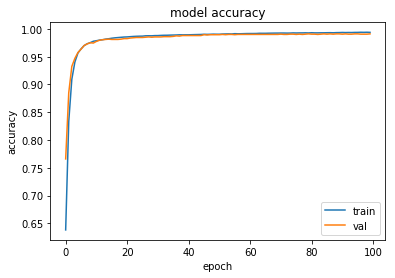

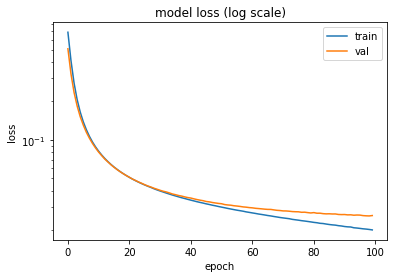

In [6]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()

In [7]:
from keras.models import load_model
from sklearn.metrics import log_loss

model = load_model("ResNet-head-Dense2.h5")
with h5py.File("ResNet50-300x300_codes-test.h5") as hf:
     X_test = hf["X_test"][:]


In [8]:
Y_train_preds=model.predict(X_train)
print(log_loss(Y_train,Y_train_preds))
Y_valid_preds=model.predict(X_valid)
print(log_loss(Y_valid,Y_valid_preds))

0.0197293185243
0.0257146473853


In [9]:
for i in range(1,10):
    m=i/100.0
    print(m,log_loss(Y_valid,Y_valid_preds.clip(min=m, max=1-m)))
    
for i in range(1,10):
    m=i/100.0
    print(m,log_loss(Y_train,Y_train_preds.clip(min=m, max=1-m)))


0.01 0.0338038361608
0.02 0.0428599127205
0.03 0.0522148580924
0.04 0.0617933657486
0.05 0.0715946517959
0.06 0.0815958315395
0.07 0.0917674249485
0.08 0.102088050611
0.09 0.112511019211
0.01 0.0277817506332
0.02 0.0368027210934
0.03 0.0461583567202
0.04 0.0557684585934
0.05 0.0655785367798
0.06 0.0755731418931
0.07 0.0857064590752
0.08 0.0959931560553
0.09 0.106439248855


In [10]:
import re
datagen = ImageDataGenerator()
test_batches = datagen.flow_from_directory("test", model.input_shape[1:3], shuffle=False, batch_size=32, class_mode=None)
#test_codes = model.predict_generator(test_batches, test_batches.nb_sample)

ids = [re.split('/|\.',x)[1] for x in test_batches.filenames]


Found 12500 images belonging to 1 classes.


In [11]:
Y_test = model.predict(X_test)

In [12]:
Y_test_csv=np.column_stack((ids,Y_test[:,1]))
np.savetxt('Y_test_ResNet-head-Dense2.csv',Y_test_csv, fmt="%s,%s", header=("id,label"),comments='')

In [13]:
Y_test_csv=np.column_stack((ids,Y_test[:,1].clip(min=0.02, max=0.98)))
np.savetxt('Y_test_ResNet-head-Dense2-clipped.csv',Y_test_csv, fmt="%s,%s", header=("id,label"),comments='')